In [ ]:
!pip install einops
!pip install bitsandbytes
!pip install accelerate
!pip install underthesea

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import os
import requests

import torch
from torch import nn
from torchvision import transforms
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForMaskedLM
from transformers import BitsAndBytesConfig
import underthesea
import cv2

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DataLoader

Có hai bộ data là UITVIC và KTVIC:
- UITVIC của trường UIT, chủ yếu là ảnh và caption tiếng việt (chú thích ảnh) về các môn thể thao như tennis, bóng chày, bóng đá,... Nguồn ảnh lấy từ bộ dữ liệu nổi tiếng COCO. Bộ dữ liệu gồm có 2695 ảnh train và 231 ảnh test.
- KTVIC của VNU, cũng là ảnh và caption nhưng mẫu ảnh đa dạng hơn, có thể là ảnh đồ ăn, nhà cửa, xe cộ,... Bộ ảnh gồm 3769 ảnh train và 558 ảnh test.
- Ở cả hai bộ data, mỗi ảnh có thể có một hoặc nhiều captions, thế nên ảnh đó có thể train nhiều lần với các captions khác nhau.
- Tất cả ảnh đều được xử lí theo chuẩn của resnet50 (resize, crop, normalize) và thực hiện data augmentation (random rotation, horizontal flip) để tránh overfit nếu train 1 ảnh nhiều lần.
- Đối với bộ data của UIT, do captions chưa được word tokenize nên sẽ được pass qua thư viện underthesea để xử lý trước. Điều này là bắt buộc vì mô hình phobert (dùng làm text encoder cho CLIP) chỉ nhận inputs đã đc word tokenize.

In [5]:
class UITVIC_DATA(Dataset):
    def __init__(self, json_path, img_dir, augment=False, only_image=False):
        self.img_dir = img_dir
        self.augment = augment
        self.only_image = only_image
        with open(json_path) as f:
            self.data = json.load(f)

        self.images = {item['id']: item['file_name'] for item in self.data['images']}
        self.annotations =  pd.DataFrame(self.data['annotations']).drop('id', axis=1)
        
        if self.augment:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.only_image:
            img_id = list(self.images.keys())[idx]
            img_filename = self.images[img_id]
            img_path = os.path.join(self.img_dir, img_filename)
            img = cv2.imread(img_path)
            img = self.transform(img)
            return img
        else:
            annotation = self.annotations.iloc[idx]['caption']
            img_filename = self.images[self.annotations.iloc[idx]['image_id']]
            img_path = os.path.join(self.img_dir, img_filename)
            img = cv2.imread(img_path)
            img = self.transform(img)
            return img, underthesea.word_tokenize(annotation, format="text")

In [6]:
class KTVIC_DATA(Dataset):
    def __init__(self, json_path, img_dir, augment=False, only_image=False):
        self.img_dir = img_dir
        self.augment = augment
        self.only_image = only_image
        with open(json_path) as f:
            self.data = json.load(f)

        self.images = {item['id']: item['filename'] for item in self.data['images']}
        self.annotations = {item['id']: item for item in self.data['annotations']}
        self.dup_images = self.get_dup_img()

        if self.augment:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.ToTensor()

    def get_dup_img(self):
        #duplicate ảnh trong trường hợp một ảnh có nhiều caps. Phương pháp tạm thời :)) 
        #có thể cải tiến thêm để load batch nhanh hơn!
        dup_images = {}
        for item in self.data['annotations']:
            dup_images[item['id']] = self.images[item['image_id']]
        return dup_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.only_image:
            img_id = list(self.images.keys())[idx]
            img_filename = self.images[img_id]
            img_path = os.path.join(self.img_dir, img_filename)
            img = cv2.imread(img_path)
            img = self.transform(img)
            return img
        else:
            img_id = list(self.dup_images.keys())[idx]
            img_filename = self.dup_images[img_id]
            img_path = os.path.join(self.img_dir, img_filename)
            img = cv2.imread(img_path)
            img = self.transform(img)

            annotation = self.annotations[idx]['segment_caption']

            return img, annotation

In [7]:
uitvic = UITVIC_DATA(json_path='/kaggle/input/uitviic-caps/uitvic_dataset/uitvic_captions_train2017.json', 
                     img_dir='/kaggle/input/uitviic-caps/uitvic_dataset/coco_uitvic_train/coco_uitvic_train',
                     augment=True)
uitvic_loader = DataLoader(uitvic, batch_size=64, shuffle=True)

In [8]:
ktvic = KTVIC_DATA(json_path='/kaggle/input/ktvic-dataset/ktvic_dataset/train_data.json', 
                        img_dir='/kaggle/input/ktvic-dataset/ktvic_dataset/train-images',
                        augment=True)
ktvic_loader = DataLoader(ktvic, batch_size=64, shuffle=True)

In [9]:
images, sentences = next(iter(uitvic_loader))

In [10]:
# reverse chuẩn hóa để in ảnh ra dễ nhìn hơn.
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

'Vận_động_viên tennis nam đang cầm vợt nhảy lên đỡ bóng cao .'

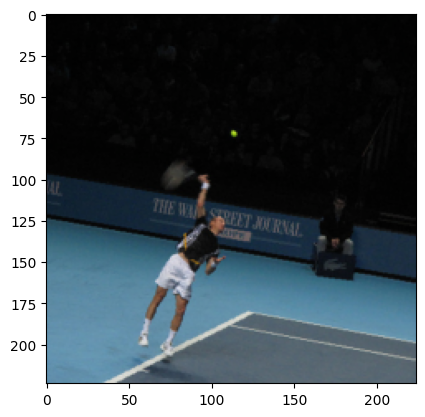

In [11]:
img_id = 10
image_np = inv_normalize(images[img_id]).permute(1, 2, 0).numpy()
image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
sentences[img_id]

In [12]:
data_loader = {'uitvic':uitvic_loader,'ktvic':ktvic_loader}

# CLIP

Mô hình CLIP bao gồm hai encoders, một dùng để encode text và một để encode hình ảnh. Ý tưởng chính của CLIP là tạo một mô hình có thể liên kết được giữa hai encoders này để tính toán được sự giống nhau giữa texts và images.

## Load BERT

Phần text encoder sẽ sử dụng model phoBert được train bởi vinAI. Để output's shape của mô hình cố định ta sẽ chỉ giới hạn input tối đa 50 tokens đồng thời thực hiện padding nếu input không đủ 50 tokens. Sau đó output ta sẽ chỉ trích ra token đầu tiên (token < s >) vì token này đã được train để nắm được ý nghĩa chung của cả câu.

In [13]:
tokenizer_bert = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
phobert = AutoModelForMaskedLM.from_pretrained("vinai/phobert-base-v2")

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [14]:
phobert.load_state_dict(torch.load('/kaggle/input/clip-weight-final/phobert_encoder.pt', map_location=device))

<All keys matched successfully>

In [15]:
# phobert = phobert.to(device)
# encoded_inputs = [tokenizer_bert.encode_plus(sentence, max_length=50, truncation=True, padding='max_length') for sentence in sentences]
# input_ids = torch.tensor([inputs['input_ids'] for inputs in encoded_inputs]).to(device)
# attention_mask = torch.tensor([inputs['attention_mask'] for inputs in encoded_inputs]).to(device)
# features = phobert(input_ids, attention_mask=attention_mask)
# features[0][:, 0, :].shape

In [16]:
# for inputs in encoded_inputs:
#     # Get the input ids
#     input_ids = inputs['input_ids']
#     # Decode the input ids back into a sentence
#     sentence = tokenizer_bert.decode(input_ids)

#     print(sentence)
#     print("\n")

## Load Vision Encoder

Với vision encoder, ta sẽ dùng resnet50 - một mô hình cũng đã quá phổ biến trong task image classification.

In [17]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s] 


In [18]:
# from transformers import CLIPModel, CLIPProcessor
# Access the vision encoder
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# vi_encoder = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").vision_model
# vi_encoder.to(device)
# def image_encoder(image, trainable = False):
#     for param in vi_encoder.parameters():
#         param.requires_grad = trainable
#     inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
#     image_tensor = inputs["pixel_values"]
#     output = vi_encoder(image_tensor)
#     return output[0]

In [20]:
# resnet.to(device)
# output = vi_encoder(images.to(device))
# output.shape

In [19]:
resnet.load_state_dict(torch.load('/kaggle/input/clip-weight-final/resnet_encoder.pt', map_location=device))

<All keys matched successfully>

## Let me Cook

Sau khi đã chuẩn bị xong ba nguyên liệu, data, text encoder, image encoder thì điều cuối cùng ta phải làm là tạo một projection head. Đây chính là layer sẽ tạo ra sự liên kết giữa hai encoders bằng cách co dần shape của hai output (từ hai encoders) về thành output_dim (hay còn gọi là latent space) - ở đây chọn output_dim là 256.

In [21]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.gelu = nn.GELU()
        self.layer_norm = nn.LayerNorm(output_dim)
        self.drop = nn.Dropout(0.1)
    def forward(self, x):    
        linear1 = self.linear1(x)
        x = self.gelu(linear1)
        x = self.linear2(x)
        x = self.drop(x)
        x = x + linear1
        x = self.layer_norm(x)
        return x

In [22]:
class CLIP(nn.Module):
    def __init__(self, resnet, phobert, device):
        super().__init__()
        self.resnet = resnet.to(device)
        self.phobert = phobert.to(device)
        self.text_proj = ProjectionHead(64001, 256).to(device)
        self.img_proj = ProjectionHead(1000, 256).to(device)
    def predict(self, img, sentence):
        with torch.no_grad():
            image_features = self.image_encoder(img)
            text_features = self.text_encoder(sentence)
            image_embeddings = self.img_proj(image_features)
            text_embeddings = self.text_proj(text_features)
            similarity = text_embeddings @ image_embeddings.T
        return similarity
    def trainable(self, encoder_name, status = False):
        if encoder_name == "image_encoder":
            for param in self.resnet.parameters():
                param.requires_grad = status
        elif encoder_name == "text_encoder":
            for param in self.phobert.parameters():
                param.requires_grad = status
        else: print("Can't find encoder!")
    def text_encoder(self, list_sentence):
        encoded_inputs = [tokenizer_bert.encode_plus(sentence, max_length=50, truncation=True, padding='max_length') for sentence in list_sentence]
        input_ids = torch.tensor([inputs['input_ids'] for inputs in encoded_inputs]).to(device)
        attention_mask = torch.tensor([inputs['attention_mask'] for inputs in encoded_inputs]).to(device)
        features = phobert(input_ids, attention_mask=attention_mask)
        return features[0][:, 0, :]
    def image_encoder(self, image):
        output = resnet(image.to(device))
        return output
    def forward(self, img, sentence)
        image_features = self.image_encoder(img)
        text_features = self.text_encoder(sentence)
        image_embeddings = self.img_proj(image_features)
        text_embeddings = self.text_proj(text_features)
        # Prediction
        logits = text_embeddings @ image_embeddings.T
        # Calculating Label
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax((images_similarity + texts_similarity) / 2.0, dim=-1)
        # Calculating Loss
        texts_loss = self.__cross_entropy(logits, targets, reduction='mean')
        images_loss = self.__cross_entropy(logits.T, targets.T, reduction='mean')
        loss = (texts_loss + images_loss)/2.0
        return loss
    def __cross_entropy(self, preds, targets, reduction='none'):
        log_softmax = nn.LogSoftmax(dim=-1)
        loss = (-targets * log_softmax(preds)).sum(1)
        if reduction == "none":
            return loss
        elif reduction == "mean":
            return loss.mean()

In [23]:
model = CLIP(resnet, phobert, device)

In [24]:
model.load_state_dict(torch.load('/kaggle/input/clip-weight-final/clip_vn.pt', map_location=device))

<All keys matched successfully>

10 epochs đầu ta sẽ khởi động nhẹ bằng cách freeze lại hai encoders để projection head có thời gian thích nghi trước khi train.

In [25]:
# Warm up
# optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
# epochs = 10
# #Freeze pretrained
# model.trainable(encoder_name="image_encoder", status=False)
# model.trainable(encoder_name="text_encoder", status=False)
# for epoch in range(epochs):
#     for batch in data_loader['ktvic']:
#         img, annotation = batch
#         optimizer.zero_grad()
#         loss = model(img, annotation)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}/{epochs} finished, loss: {loss.item()}")

In [26]:
# hist = []
# optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
# epochs = 500
# loader = None
# #UNFreeze pretrained
# model.trainable(encoder_name="image_encoder", status=True)
# model.trainable(encoder_name="text_encoder", status=True)
# for epoch in range(epochs):
#     gacha = np.random.randint(0,2)
#     if gacha == 0: loader = data_loader['uitvic']
#     else: loader = data_loader['ktvic']
#     for batch in loader:
#         img, annotation = batch
#         optimizer.zero_grad()
#         loss = model(img, annotation)
#         hist.append(loss.item())
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}/{epochs} finished, loss: {loss.item()}")

In [28]:
# plt.plot(hist)

# Test Area

In [36]:
# test = UITVIC_DATA(json_path='/kaggle/input/uitviic-caps/uitvic_dataset/uitvic_captions_test2017.json', 
#                     img_dir='/kaggle/input/uitviic-caps/uitvic_dataset/coco_uitvic_test/coco_uitvic_test',
#                     only_image=True,
#                     augment=True)
# test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [46]:
test = KTVIC_DATA(json_path='/kaggle/input/ktvic-dataset/ktvic_dataset/test_data.json', 
                  img_dir='/kaggle/input/ktvic-dataset/ktvic_dataset/public-test-images',
                  only_image=True,
                  augment=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

# 

In [47]:
#text = "có khu chợ, siêu thị, gian hàng, tiệm, quầy bán"
#text = "có tòa nhà, khu phố, đường phố"
#text = "có thuyền, xuồng"
#text = "có sông hồ, bãi biển"

#text = "có xe máy ở trên đường"
#text = "có ô tô ở trên đường"
#text = "có người đi bộ ở trên đường"
#text = "có thuyền ở dưới nước"
#text = "có một đám đông"

In [48]:
all_scores = []
count = 1
text = "có một con thuyền ở dưới nước"

for batch in test_loader:
    img = batch
    find_match = model.predict(img, [underthesea.word_tokenize(text, format="text")]*len(img))
    all_scores.append(find_match)
    print("Batch ",count," Done")
    count+=1
for i in range(len(all_scores)):
    all_scores[i] = all_scores[i].sum(dim=0)
results_tensor = torch.cat(all_scores)
top_values, indices = torch.topk(results_tensor, k=6, dim=0)

Batch  1  Done
Batch  2  Done
Batch  3  Done
Batch  4  Done
Batch  5  Done
Batch  6  Done
Batch  7  Done
Batch  8  Done
Batch  9  Done
Batch  10  Done
Batch  11  Done
Batch  12  Done


libpng warning: iCCP: known incorrect sRGB profile


Batch  13  Done
Batch  14  Done
Batch  15  Done
Batch  16  Done
Batch  17  Done
Batch  18  Done


In [49]:
top_values

tensor([845.2349, 736.3389, 728.2670, 719.2420, 672.7037, 638.0193],
       device='cuda:0')

Text(0.5, 0.79, 'có một con thuyền ở dưới nước')

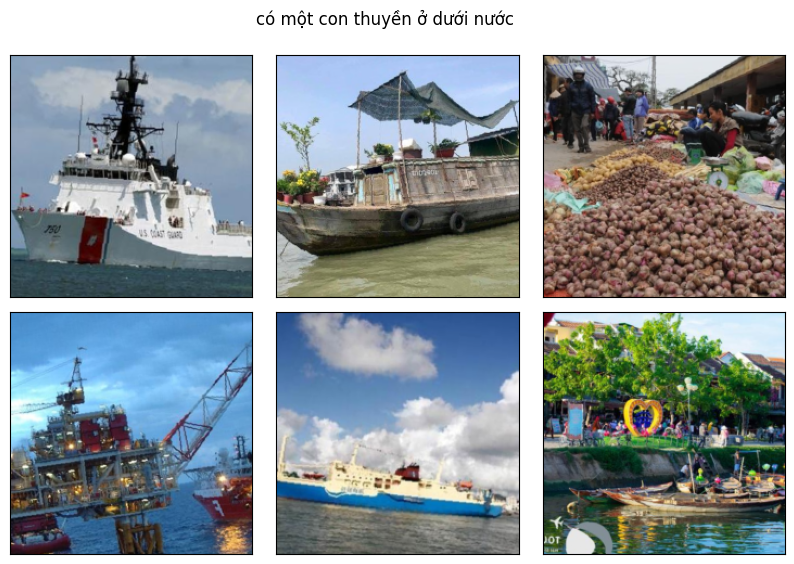

In [50]:
fig = plt.figure(figsize=(10, 10))

for i in range(len(indices)):
    image = inv_normalize(test[indices[i].item()]).permute(1, 2, 0)
    image_rgb = cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image_rgb)
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=-0.5)
plt.suptitle(text, y=0.79)

In [42]:
# torch.save(model.state_dict(), '/kaggle/working/clip_vn.pt')
# torch.save(phobert.state_dict(), '/kaggle/working/phobert_encoder.pt')
# torch.save(resnet.state_dict(), '/kaggle/working/resnet_encoder.pt')